<a href="https://colab.research.google.com/github/rubyvanrooyen/ARIWS-Cookbook/blob/main/tutorials/MeerKAT_Array_UV_coverage_manual_calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and installation

Install mpl-toolkits.basemap dependencies

In [1]:
!apt install python3-matplotlib python3-pyproj python3-pyshp python-mpltoolkits.basemap-data libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-lyx javascript-common libjs-jquery libjs-jquery-ui
  python-matplotlib-data python3-cycler python3-dateutil python3-olefile
  python3-pil python3-pyparsing python3-six python3-tz ttf-bitstream-vera
Suggested packages:
  apache2 | lighttpd | httpd libgdal-doc libjs-jquery-ui-docs
  python-cycler-doc dvipng gir1.2-gtk-3.0 ghostscript inkscape ipython3
  python-matplotlib-doc python3-cairocffi python3-gi-cairo python3-gobject
  python3-nose python3-pyqt4 python3-scipy python3-sip python3-tornado
  texlive-extra-utils texlive-latex-extra ttf-staypuft python-pil-doc
  python3-pil-dbg python-pyparsing-doc
The following NEW packages will be installed:
  fonts-lyx javascript-common libgeos-dev libjs-jquery libjs-jquery-ui
  python-matplotlib-data python-mpltoolkits.basemap-data python3-cycler
  python3-dateutil python3-matplotlib python3-o

Install basemap version 1.2.0 (bug fix version of default version 1.1.0)

You will be asked to restart runtime, restart before continuing to next cell

In [2]:
!pip install https://github.com/matplotlib/basemap/archive/v1.2.0rel.zip

     / 149.2MB 432kB/s
  Created wheel for basemap: filename=basemap-1.2.0-cp36-cp36m-linux_x86_64.whl size=121645994 sha256=9fe72f607c03efabf3e2f05599d7da832554febaa3de8a258f988501eb515fc1
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_2vyh5j/wheels/3c/ad/51/cf7c93cb1cbf1d8ecec0acc46ddec72e1089ea9edb6a59b500
Successfully built basemap


Run after restarting runtime to check installation success

In [1]:
from mpl_toolkits.basemap import Basemap

# Import libraries

In [2]:
import astropy.constants as phys
import ephem
import matplotlib.pyplot as plt
import numpy as np
import yaml

from astropy import units as u
from astropy.coordinates import Longitude, Latitude, EarthLocation
from astropy.coordinates import ICRS, SkyCoord
from datetime import datetime, timedelta
from numpy import recarray

from ipywidgets import widgets
from IPython.display import display

# Read MeerKAT config file with antenna positions

In [3]:
class MKAT(object):
    def __init__(self, mkat_config):
        self.ref_position = None
        arr_desc = {'names': ('name', 'east', 'north', 'up', 'location'),
                    'formats': ('S5', float, float, float, EarthLocation)}
        self.antennas = recarray((0,), dtype=arr_desc)
        self.build_array(mkat_config)
        
        self.frequency = 1420e6 / u.s
        self.wavelength = phys.c / self.frequency
        self.nr_antennas = len(self.antennas)
        self.nr_baselines = (self.nr_antennas * (self.nr_antennas - 1)) // 2
        
        self.observer = self.ephem_observer()
        
    def build_array(self, filename):
        """Read array default .yaml file."""
        with open(filename, "r") as stream:
            data = yaml.safe_load(stream)
        self.get_reference(data['reference'])
        self.get_antennas(data['antennas'])
 
    def get_reference(self, ref_position):
        """General Earth position for the Telescope"""
        self.ref_LAT = Latitude(ref_position['latitude'],
                                u.degree,
                                copy=False)
        self.ref_LON = Longitude(ref_position['longitude'],
                                 u.degree,
                                 wrap_angle=180. * u.degree,
                                 copy=False)
        self.ref_ALT = u.Quantity(ref_position['altitude'],
                                  u.m,
                                  copy=False)
        self.ref_position = EarthLocation(lat=self.ref_LAT,
                                          lon=self.ref_LON,
                                          height=self.ref_ALT)
 
    def get_antennas(self, antennas):
        """ENU coordinates per antenna"""
        if self.ref_position is not None:
            [ref_x, ref_y, ref_z] = self.ref_position.to_geocentric()

        self.antennas.resize(len(antennas))
        for cnt, antenna in enumerate(antennas):
            ant_ = [item.strip() for item in antenna.split(",")]
            for item_ in ant_:
                for prefix_ in ('name', 'east', 'north', 'up'):
                    val_ =  None
                    if item_.startswith(prefix_):
                        val_ =  item_.split('=')[-1].strip()
                    if val_ is not None:
                        self.antennas[cnt][prefix_] = val_
            if self.ref_position is not None:
                L_sin = np.sin(self.ref_LAT.rad)
                L_cos = np.cos(self.ref_LAT.rad)
                x = -L_sin * self.antennas[cnt]['north'] + \
                    L_cos * self.antennas[cnt]['up']
                y = self.antennas[cnt]['east']
                z = L_cos * self.antennas[cnt]['north'] + \
                    L_sin * self.antennas[cnt]['up']
                # MeerKAT antenna positions, ITRF, m
                self.antennas[cnt]['location'] = EarthLocation(x=(ref_x.value+x)*u.m,
                                                               y=(ref_y.value+y)*u.m,
                                                               z=(ref_z.value+z)*u.m)

    def ephem_observer(self):
        lon = self.ref_position.geodetic[0].degree
        lat = self.ref_position.geodetic[1].degree
        alt = self.ref_position.geodetic[2].value
        observer = ephem.Observer()
        observer.lon = str(lon)
        observer.lat = str(lat)
        observer.elevation = alt
        return observer
    
    def baselines(self):
        """The function evaluates baselines lenghts
           and the angle between antennas
        """
        P = np.array([self.antennas['north'],
                      self.antennas['east']]).T
        # antenna position in wavelength units
        P = P / self.wavelength.value  # baseline

        bl_length = np.zeros((self.nr_baselines, ))
        bl_az_angle = np.zeros((self.nr_baselines, ))
        cnt = 0
        for idx0 in range(self.nr_antennas):
            for idx1 in range(idx0 + 1, self.nr_antennas):
                bl_len_p0 = (P[idx0, 0] - P[idx1, 0])**2
                bl_len_p1 = (P[idx0, 1] - P[idx1, 1])**2
                bl_length[cnt] = np.sqrt(bl_len_p0 + bl_len_p1)
                bl_az_angle[cnt] = np.arctan2((P[idx0, 1] - P[idx1, 1]),
                                              (P[idx0, 0] - P[idx1, 0]))
                cnt += 1

        return bl_length, bl_az_angle

In [4]:
#upload mkat_antennas.yml
from google.colab import files
uploaded = files.upload()

Saving mkat_antennas.yml to mkat_antennas.yml


In [5]:
mkat = MKAT('/content/mkat_antennas.yml')

In [6]:
def decode(text_):
    if isinstance(text_, str):
        text = text_
    else:
        text = text_.decode("utf-8")
    return text

# Get array
arr_latitude = []
arr_longitude = []
arr_names = []
for antenna in mkat.antennas:
    arr_names.append(decode(antenna['name']))
    arr_latitude.append(antenna['location'].lat.value)
    arr_longitude.append(antenna['location'].lon.value)

# Plotting functionality

In [7]:
class UVplot(object):
    def __init__(self,
                 latitude,
                 declination,
                 elevation):
        self.lat = latitude
        self.dec = declination
        self.elev = elevation

    def __baseline_to_xyz__(self,
                            baseline_lengths,
                            baseline_azimuth):
        """The following function transform baseline to x,y,z coordinates
            elevation: Elevation angle in radian
            The result is a vector of (x,y,z) with unit the same as baseline length
            Interferometry and Synthesis in Radio Astronomy, Chapter 4, Equation 4.4
        """
        x0 = np.cos(self.lat) * np.sin(baseline_azimuth)
        x1 = np.sin(self.lat) * np.cos(baseline_azimuth) * np.cos(self.elev)
        x = x0 - x1
        y = np.cos(baseline_azimuth) * np.sin(self.elev)
        z0 = np.sin(self.lat) * np.sin(baseline_azimuth)
        z1 = np.cos(self.lat) * np.cos(baseline_azimuth) * np.cos(self.elev)
        z = z0 + z1
        xyz = np.array([(x, y, z)])
        return baseline_lengths * xyz.T

    def __xyz_to_baseline__(self,
                            hour_angle):
        """Transform x, y, z to u, v, w components
           hour_angle: Source hour angle in radians
           dec: Source declination in radian
           Interferometry and Synthesis in Radio Astronomy, Chapter 4, Equation 4.1
        """
        a1 = np.sin(hour_angle)
        a2 = np.cos(hour_angle)
        a3 = 0.

        b1 = -1 * np.sin(self.dec) * np.cos(hour_angle)
        b2 = np.sin(self.dec) * np.sin(hour_angle)
        b3 = np.cos(self.dec)

        c1 = np.cos(self.dec) * np.cos(hour_angle)
        c2 = -1 * np.cos(self.dec) * np.sin(hour_angle)
        c3 = np.sin(self.dec)

        return np.array([(a1, a2, a3),
                         (b1, b2, b3),
                         (c1, c2, c3)])

    def track_uv(self,
                 ha_range,
                 bl_length,
                 bl_azimuth,
                 timeslots):
        """Evaluate the track of a single antenna pair
           The function return a set of u,v,w components
        """
        uvw = np.zeros((timeslots, 3), dtype=float)
        for i in range(timeslots):
            uvw[i, :] = np.dot(self.__xyz_to_baseline__(ha_range[i]),
                               self.__baseline_to_xyz__(bl_length,
                                                        bl_azimuth)).T
        return uvw

    def uvMask(self,
               ha_range,
               bl_length,
               bl_azimuth,
               timeslots,
               maxsize,
               uvscaling):
        maskmat = np.zeros((maxsize, maxsize))
        uvw = self.track_uv(ha_range,
                            bl_length,
                            bl_azimuth,
                            timeslots)
        sctrl = maxsize // 2 + 1
        for i in range(timeslots):
            maskmat[sctrl + int(np.ceil(uvw[i, 0] * uvscaling)),
                    sctrl + int(np.ceil(uvw[i, 1] * uvscaling))] = 1.
            maskmat[sctrl - int(np.ceil(uvw[i, 0] * uvscaling)),
                    sctrl - int(np.ceil(uvw[i, 1] * uvscaling))] = 1.
        return maskmat

    def plot_uv(self,
                ha_range,
                bl_length,
                bl_azimuth,
                timeslots,
                comment=''):
        """UV coverage graph"""
        nr_baselines = len(bl_length)
        fig, ax = plt.subplots(nrows=1, ncols=1,
                               figsize=(20, 13),  # W x H
                               facecolor='white')
        for i in range(nr_baselines):
            uv = self.track_uv(ha_range,
                               bl_length[i],
                               bl_azimuth[i],
                               timeslots)
            ax.plot(uv[:, 0], uv[:, 1], 'b.', markersize=2)
            ax.plot(-uv[:, 0], -uv[:, 1], 'r.', markersize=2)
        ax.set_xlabel('u')
        ax.set_ylabel('v')
        ax.set_title('Declination {} deg: UV coverage'
                     .format(comment))
        return fig, ax

    def plot_mask(self,
                  mask,
                  psf,
                  comment=''):
        """Display simulated beamshape"""
        fig, ax = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 13),  # W x H
                               facecolor='white')
        ax[0].imshow(mask)
        [nr, nc] = np.shape(mask)
        ax[0].set_xlim(0.5 * nr - 0.25 * nr,
                       0.5 * nr + 0.25 * nr)
        ax[0].set_ylim(0.5 * nc - 0.25 * nc,
                       0.5 * nc + 0.25 * nc)
        ax[0].set_xlabel('u')
        ax[0].set_ylabel('v')
        ax[0].set_title('uv coverage, "%s"' % comment)

        ax[1].imshow(psf,
                     interpolation='gaussian',
                     origin='lower',
                     vmin=psf.min() / 1000.,
                     vmax=psf.max())
        [nr, nc] = np.shape(psf)
        ax[1].set_xlim(0.5 * nr - 0.25 * nr,
                       0.5 * nr + 0.25 * nr)
        ax[1].set_ylim(0.5 * nc - 0.25 * nc,
                       0.5 * nc + 0.25 * nc)
        ax[1].set_xlabel('u')
        ax[1].set_ylabel('v')
        ax[1].set_title('psf, "%s"' % comment)

        return fig, ax

In [8]:
# hour angle range in hours given nr of timeslots
# At meridian the hour angle is 0.000 degree,
# with the time before meridian crossing expressed as negative degrees,
# and the local time after expressed as positive degrees.
def get_ha_range(telescope,
                 target,
                 start_time,
                 duration,
                 ntimeslots=50):

    start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    stop_time = start_time + timedelta(seconds=duration)

    telescope.observer.date = ephem.Date(start_time)
    star = ephem.FixedBody()
    star._ra = target.ra.degree
    star._dec = target.dec.degree
    rise_time = telescope.observer.previous_rising(star)
    set_time = telescope.observer.next_setting(star,
                                               start=rise_time).datetime()
    if start_time > set_time:
        rise_time = telescope.observer.next_rising(star)
        set_time = telescope.observer.next_setting(star,
                                                   start=rise_time).datetime()
    if start_time < rise_time.datetime():
        start_time = rise_time.datetime()

    transit_time = telescope.observer.next_transit(star,
                                                   start=rise_time).datetime()

    if stop_time > set_time:
        stop_time = set_time
        duration = (stop_time - start_time).total_seconds()

    time_step = float(duration) / float(ntimeslots)
    dtime = np.arange(0, duration + time_step, time_step)
    ha_range = np.zeros((dtime.size), dtype=float)
    for cnt, dt in enumerate(dtime):
        time_ = start_time + timedelta(seconds=dt)
        if time_ < transit_time:
            dt_transit = -(transit_time - time_).total_seconds()
        else:
            dt_transit = (time_ - transit_time).total_seconds()
        ha_range[cnt] = dt_transit / 3600.

    # 1hr = 15 deg = pi/12 rad
    return ha_range * np.pi / 12.

def coverage(telescope,
             target,
             start_time=None,
             duration=300,  # sec
             ntimeslots=10):

    # declination convert in radian
    dec = np.radians(target.dec.degree)
    # telescope latitude
    latitude = telescope.ref_position.geodetic[1].radian
    # number of time slots
    ntimeslots = ntimeslots
    # hour angle range from target sky track
    ha_range = get_ha_range(telescope,
                            target,
                            start_time,
                            duration,
                            ntimeslots=ntimeslots)

    # baseline lengths and azimuth angles
    [bl_length,
     bl_az_angle] = telescope.baselines()

    # Plot the uv-Coverage
    uvplot = UVplot(latitude=latitude,
                    declination=dec,
                    elevation=0.)

    fig, ax = uvplot.plot_uv(ha_range,
                             bl_length,
                             bl_az_angle,
                             ntimeslots,
                             comment='{:.0f}'.format(dec))
    uv = uvplot.track_uv(ha_range=ha_range,
                         bl_length=bl_length[-1],
                         bl_azimuth=bl_az_angle[-1],
                         timeslots=ntimeslots)
    mb = 5 * np.sqrt((uv**2).sum(1)).max()
    ax.set_xlim(-mb, mb)
    ax.set_ylim(-mb, mb)
    plt.axis('equal')
    plt.gca().invert_xaxis()

    # Show UV mask and synthesize beam, natural weighting without a taper
    # number of pixels
    npix = 2**10  # should be a power of two
    # kernel matrix
    mask = np.zeros((npix, npix))
    # uv-grid scale factor to fit tracks into matrix
    uvscale = npix / 2 / mb * 0.95 * 0.5
    for i in range(telescope.nr_baselines):
        mask = mask + uvplot.uvMask(ha_range,
                                    bl_length[i],
                                    bl_az_angle[i],
                                    ntimeslots,
                                    npix,
                                    uvscale)

    psf = np.fft.ifftshift(np.fft.ifft2(mask.T)).real
    uvplot.plot_mask(mask.T,
                     psf,
                     comment="natural weighting")

# Select antennas for array

In [9]:
# widget setup for selection display
class antennas():
    def __init__(self):
        
        self.antennas = {}
        self.construct_array()
        
        # build widget grid
        for ant_name in self.antennas.keys():
            self.antennas[ant_name] = self.ant_checkbox(ant_name)
        
    def construct_array(self):
        for cntr in range(0, 64):
            ant_name = 'm{:03d}'.format(cntr)
            self.antennas[ant_name] = None        
        
    def ant_checkbox(self, ant_name):
        return widgets.Checkbox(value=True,
                                description=ant_name,
                                disabled=False,
                                indent=False) 

In [10]:
def select_antennas(ant_array):
    array_ = np.empty([4, 16], dtype=widgets.Checkbox)
    for cnt, ant in enumerate(ant_array.antennas.keys()):
        array_[cnt//16, cnt%16] = ant_array.antennas[ant]
    antennas_ = widgets.VBox([widgets.HBox(array_[0,:].tolist()),
                              widgets.HBox(array_[1,:].tolist()),
                              widgets.HBox(array_[2,:].tolist()),
                              widgets.HBox(array_[3,:].tolist())])
    display(antennas_)
ant_array = antennas()
select_antennas(ant_array)

# Target coordinates and observation information

In [11]:
# widget build for target and obs selection
class RaDec(object):
    def __init__(self):
        radec_header = widgets.Button(description='Enter celestial target coordinates',
                                      disabled=True, button_style='', tooltip='', icon='',
                                      layout={'width':'608px'})        
        header_1_0 = self._add_header_(description='J1939-6342')
        header_1_1 = self._add_header_(description='19h39m25.0264s')        
        header_1_2 = self._add_header_(description='-63d42m45.624s')  
        
        self.cname = self._add_text_(description='Name', value='J1939-6342')
        # The right ascension for this object
        self.ra = self._add_text_(description='RA', value='19h39m25.0264s')
        # The declination for this object
        self.dec = self._add_text_(description='Dec', value='-63d42m45.624s')
    
        headers_1 = widgets.HBox([header_1_0, header_1_1, header_1_2])
        celestial_target = widgets.HBox([self.cname, self.ra, self.dec])
        
        header_2 = self._add_header_(description='YYYY-MM-DD HH:mm:SS.f')
        self.starttime = self._add_text_(description='Start time', value='2013-6-21 23:00:00')
        self.duration = self._add_text_(description='Duration [sec]', value='600')
        self.timeslots = self._add_text_(description='# timeslots', value='1')
        start = widgets.VBox([header_2, widgets.HBox([self.starttime, self.duration, self.timeslots])])
        
        self.ui = widgets.VBox([radec_header,
                                headers_1,
                                celestial_target,
                                start
                               ])
    
    def _add_header_(self, description):
        header_layout = {'width':'200px', 'min_width':'200px',
                         'height':'28px', 'min_height':'28px'}
        return widgets.Button(description=description,
                              disabled=True,
                              button_style='',
                              tooltip='',
                              icon='',
                              layout=header_layout)
    
    def _add_text_(self, description, value=''):
        text_style = {'description_width': 'initial'}
        text_layout = {'width':'200px', 'min_width':'200px'}
        return widgets.Text(description=description,
                            value=value,
                            layout=text_layout,
                            style=text_style)

In [12]:
target = RaDec()
display(target.ui)

# UV coverage for selected antennas

Select the appropriate antennas from those listed above and and run the cells generate the coverage plots

J1939-6342
<SkyCoord (ICRS): (ra, dec) in deg
    (294.85427667, -63.71267333)>
2013-6-21 23:00:00 SAST


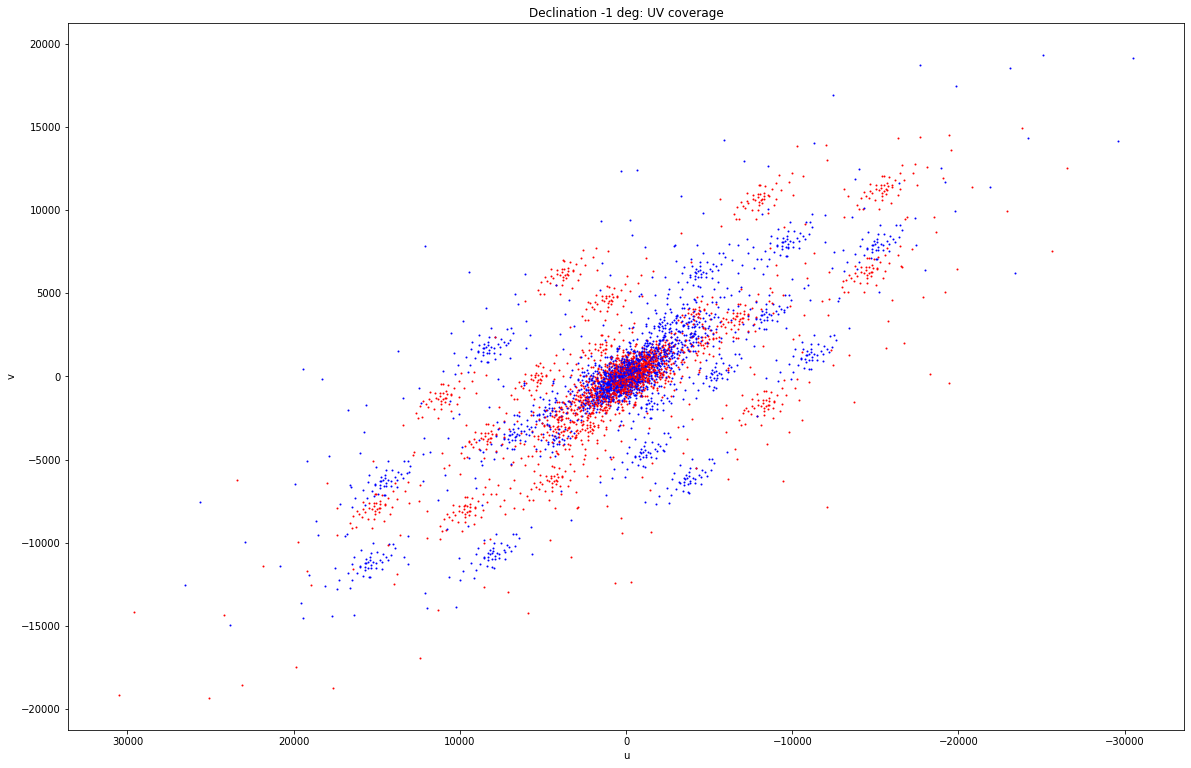

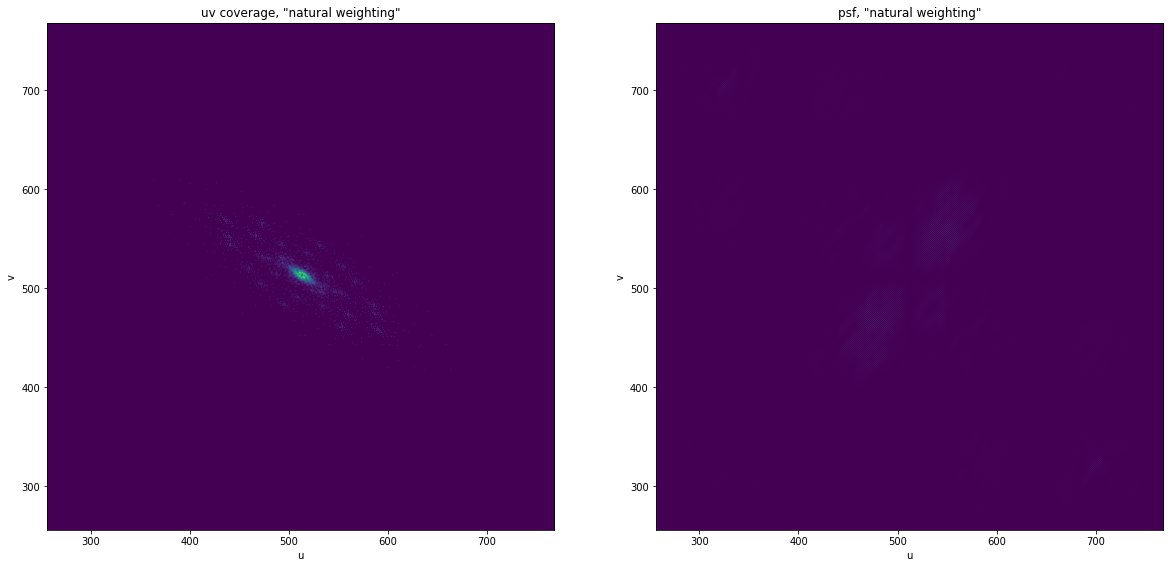

In [15]:
print(target.cname.value)
radec_coord = SkyCoord(ra=target.ra.value, dec=target.dec.value,
                       unit=(u.hourangle, u.deg),
                       frame=ICRS)
print(radec_coord)
print(f'{target.starttime.value} SAST')
coverage(telescope=mkat,
         target=radec_coord,
         start_time=target.starttime.value,
         duration=float(target.duration.value),
         ntimeslots=int(target.timeslots.value))